##  2021:Refinitiv Article series. All rights reserved
## Backtesting of Short Iron Condor option strategy on NDX

### Table of content

[Overview](#Overview)<br>
[Install and import packages](#Install-and-import-necessary-packages)<br>
1. [Section 1: Reconstruct expired option RICs](#Section-1:-Reconstruct-expired-option-RICs)<br>
    1.1 [Function for Expiration days](#1.1-Function-for-Expiration-days)<br>
    1.2 [Function for Transaction days](#1.2-Function-for-Transaction-days)<br>
    1.3 [Function to get potential RICs](#1.3-Function-to-get-potential-RICs)<br>
    1.4 [Function to validate potential RICs](#1.4-Function-to-validate-potential-RICs)<br>
2. [Section 2: Option transactions and strategy outcome](#Section-2:-option-transactions-and-strategy-outcome)<br>
    2.1 [Function to create option positions](#2.1-Function-to-create-option-positions)<br>
    2.2 [Function to offset positions](#2.2-Function-to-offset-positions)<br>
    2.3 [Function to calculate and report the outcome of the strategy](#2.3-Function-to-calculate-and-report-the-outcome-of-the-strategy)<br>
3. [Section 3: Implement and visualize short iron condor strategy](#Section-3:-Implement-and-visualize-short-iron-condor-strategy-outcome)<br>
    3.1 [Implement short iron condor strategy](#3.1-Implement-short-iron-condor-strategy)<br>
    3.2 [Visualize the outcome of the strategy](#3.2-Visualize-the-outcome-of-the-strategy)<br>
    
[Summary](#Summary)

### Overview

This article explores how you can backtest short iron condor strategy on NASDAQ 100 index (NDX). The important part of this article is the reconstruction of expired options which used to be a challenge and is reported many times in Developer community Q&A forum. The challenge is that one can't directly access expired options through a single API call. To get historical data on options, one will need to reconstruct option RICs following the logic of Refinitiv RIC construction rules and the rules specified by the exchange where the option is traded. Further, in this article, functions for RIC reconstruction and validation are presented which can be used for options on OPRA exchange traded indices and stocks. Functions reconstruct and validate AM settlement options expiring 3rd Friday of each month.

In this article, we test and visualize the profit/loss of short Iron Condor strategy with 10% and 20% OTM sizes for NDX, however one can use the functions and codes of this article to backtest other OPRA exchange traded indices (such as SPX) and equities at the same time specifying OTM sizes other than 10/20%. It should be noted, that options with different underlying assets have different liquidity and you may not get data for certain OTM ranges for some underlying assets. Current backtesting model is not in production level and is not tested on wide range of underlying assets. Except NDX, we have tested the functions on SPX and IBM which produced the required results to be used for backtesting of options on these assets. 

The article follows the following structure. In ***Section 1*** we build and present function for *expired option RIC reconstruction and validation*. ***Section 2*** introduces functions to conduct *option transactions to build iron condor legs* and *report the strategy outcome*. Also we use a function to *offset the transactions* before expiration based on *VIX movements*. Finally, in the ***Section 3***, we *implement short iron condor strategy* on NDX and *visualize the backtesting results*.

### Install and import packages

To start, we first install and import necessary packages. We use Refinitiv Data platform API to retrieve the data for which we need authorize ourselves by an app key. 

In [ ]:
!pip install eikon

In [ ]:
!pip install refinitiv.dataplatform

In [ ]:
!pip install plotly

In [ ]:
!pip install pandas_market_calendars

In [1]:
import eikon as ek
import refinitiv.dataplatform as rdp
import calendar
import numpy as np
import pandas as pd
import datetime as dt
import pandas_market_calendars as mcal
from datetime import timedelta
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.graph_objs.scatter.marker import Line
import warnings
warnings.filterwarnings("ignore")
from sys import exit

app_key = open("app_key.txt","r").read()

rdp.open_desktop_session(app_key)

### Section 1: Reconstruct expired option RICs

Below we illustrate expired RIC structure of an option with NDX as an underlying. First 3 letters indicate **name of the asset**, which can be a maximum of 5 for other assets according to RULES7. The following letter represents **Expiration month code**, which are different for put and call options and can be found in RULES2. Additionally, the letter indicating expiration month is lower case for any strike > 999.999. Next 2 digits represent **Expiration day**, which is 3rd Friday of every month for AM settled monthly options. This is followed by another 2 digits indicating the **Expiration year**. After we have 5 characters for the **Strike price** with different integral and decimal part combinations depending on the value of strike price (more can be found in RULES7). "." followed by up to 2 characters is the **Exchange code**, OPRA in the examined case. "^" symbol indicates that the option is expired, which is followed by the **Expiration month code** and **Expiration year**. Based on the following considerations, the first RIC from the below image is the RIC for NDX call option with a strike price of 12100, which was traded at OPRA Exchange and expired on November 20, 2020. The other RIC is a put option with a 10425 strike price.

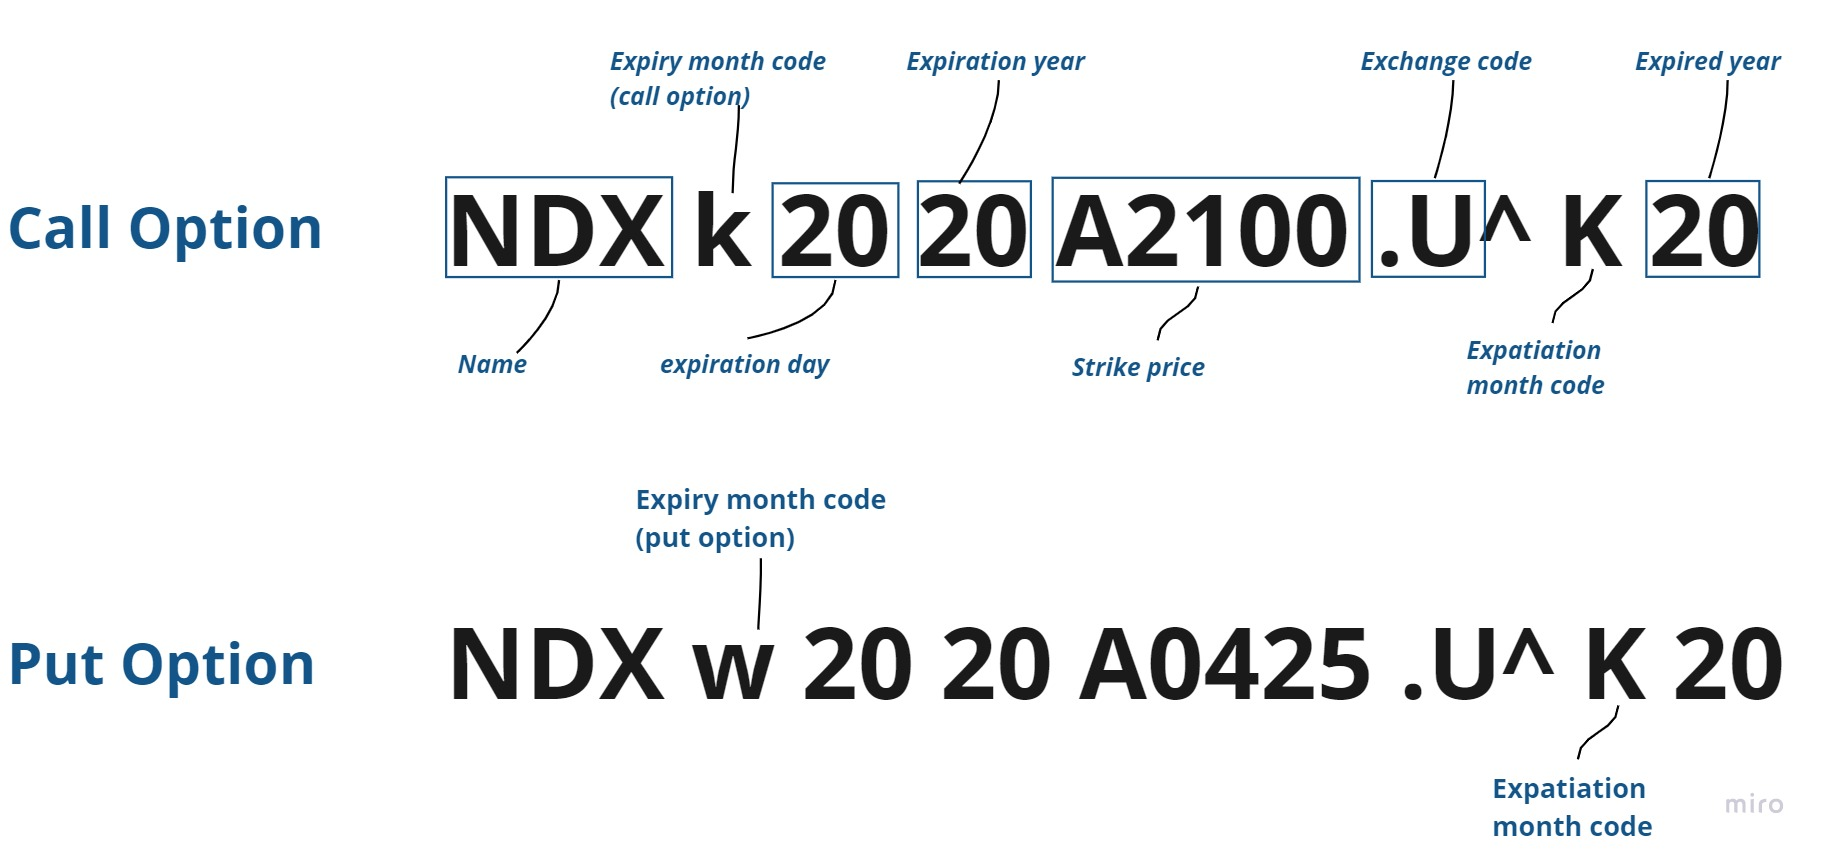

Below can be found the comprehensive list of Rules used to reconstruct expired option RICs examined in this article:

>**RULES7** | RIC rules to construct options on equities and indices (search in Workspace).

>**RULES2** | RIC Rules for Delivery Month Codes for Futures & Options (search in Workspace).

>**RULES3** and **RULES4** | RIC Rules for Exchange Identifiers (search in Workspace).

>**Guideline to pull expired options in Refinitiv Eikon** | can be accessed at [My Refinitiv](https://my.refinitiv.com/content/mytr/en/faqs/2018/09/000178972.html).

>**Guideline on RIC structure Enhancement for Strike Price 10000 and above** | can be accessed at [My Refinitiv](https://my.refinitiv.com/content/mytr/en/datanotification/DN099473.html).

>**Equity Options Product Specifications** | CBOE exchange rules to be accessed [here](https://www.cboe.com/exchange_traded_stock/equity_options_spec/).

>**SPX Options Product Specification** | CBOE exchange rules to be accessed [here](https://www.cboe.com/tradable_products/sp_500/spx_options/specifications/).

>**NDX options Product Specification** | NASDAQ Factsheet to be accessed [here](https://www.nasdaq.com/docs/2021/02/01/NDXFactSheet.pdf).

In order reconstruct RICs we need to get all the required components of RIC structure presented above. Most of the components are inputted directly to the function **get_potential_rics** introduced further in this article, whereas we have constructed separate functions to get Expiration days and Transaction days (we need this for the strike price component) as we will need to call those functions several times throughout the process.

#### 1.1 Function for Expiration days

First, we define a function to get expiration dates for each month. Since AM settled monthly options settle on the 3rd Friday of each month, we define a function which gets after having year as an input. It should be noted that the function considers also exchange holidays and if a day is a holiday the previous day is considered as suggested by exchange rules. 

***For the current and for all the following functions code explanations are made in code cell by using code comments***

In [2]:
def get_exp_dates(year):
    '''
    This functions gets expiration dates for a year for NDX options, which is the 3rd Friday of each month. 
    -----------------------------------------------
    Input:
        year(int): Year for which transaction days are requested
    Output:
        dates(dict): Dictionary of expiration days for each month of a specified year
    '''
    
    # get CBOE market holodays
    CBOE = mcal.get_calendar('CBOE_Index_Options')
    holidays = CBOE.holidays().holidays
    
    # set calendar starting from Saturday
    c = calendar.Calendar(firstweekday=calendar.SATURDAY)
    
    # get 3rd Friday for each month 
    exp_dates = {}
    for i in range(1, 13):        
        monthcal = c.monthdatescalendar(year, i)
        date = monthcal[2][-1]
        # check if found date is an holiday and get the previus date if it is
        if date in holidays:
            date = date + timedelta(-1)
        # append the date to the dictionary
        if year in exp_dates:
            exp_dates[year].append(date.day)
        else:
            exp_dates[year] = [date.day]        
    return exp_dates

Below we run the function to showcase the ouput for 2020

In [3]:
dates = get_exp_dates(2020)
dates

{2020: [17, 21, 20, 17, 15, 19, 17, 21, 18, 16, 20, 18]}

#### 1.2 Function for Transaction days

Next, we define function returning a transaction day for each of 12 months which is used for ***a. requesting underlying asset price based on which we calculate strike price also considering the specified OTM size***, and ***b. conducting monthly option transaction***.

We provide two possible days for conducting option transactions which is controlled by the function parameter: 1. First business day of each month, 2. Exiration Day of each month. We always buy/sell option contract expiring on the following month of purchase. For example, for January, 2021 we buy/sell option contract expiring on February 2021 either on the first business day, which is January 4, or expiration day, which is January 15.

In [4]:
def get_trans_days(year, trans_day = 'first'):
    '''
    This functions gets transaction days for each month of a specified year.
    --------------------------------
    Input:
        year (int): Year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'exp' indicating first or expiration day of a month respectively
    Output:
        trans_days (list): list of days for 12 month
    '''
    # get first business day of each month
    if trans_day == 'first':
        CBOE = mcal.get_calendar('CBOE_Index_Options')
        holidays = CBOE.holidays().holidays
        
        # set start and end day ranges
        start_date = str(year) + '-01' +'-01'
        end_date = str(year) + '-12' + '-31'
        trans_days = []
        
        for date in pd.date_range(start_date, end_date, freq='BMS'):
            # get the first day after the weekend after checking for holiday
            while date.isoweekday() > 5 or date in holidays:
                date += dt.timedelta(1)
            # add found day to the list
            trans_days.append(date.date().day)
            
    # get expiration dat for each month by calling function "get_exp_dates"
    elif trans_day == 'exp':
        trans_days = get_exp_dates(year)[year]
    else:
        print('Please input "first" or "exp" for transaction day')
        return
    return trans_days

Below we run the function to showcase the ouput for 2020 with a parameter value of 'first'

In [5]:
trans_days = get_trans_days(2020, 'first')
trans_days

[2, 3, 2, 1, 1, 1, 1, 3, 1, 1, 2, 1]

#### 1.3 Function to get potential RICs

As mentioned earlier, the most of the RIC components are constructed via a separate function mentioned below. This function calls the functions mentioned above and uses the input to construct other components of RIC. The function takes year, transaction day, asset name, OTM size, tolerated difference in OTM size and option type as an input and returns dictionary of potential RICs per month. For each month it produces several RICs which depend on the parameter of tolerated difference in OTM size. The reason we use tolerated difference in OTM is that it is mostly impossible to arrive at a valid strike price with any specified OTM. 

The general workflow on how the function works is illustrated in the image below: 

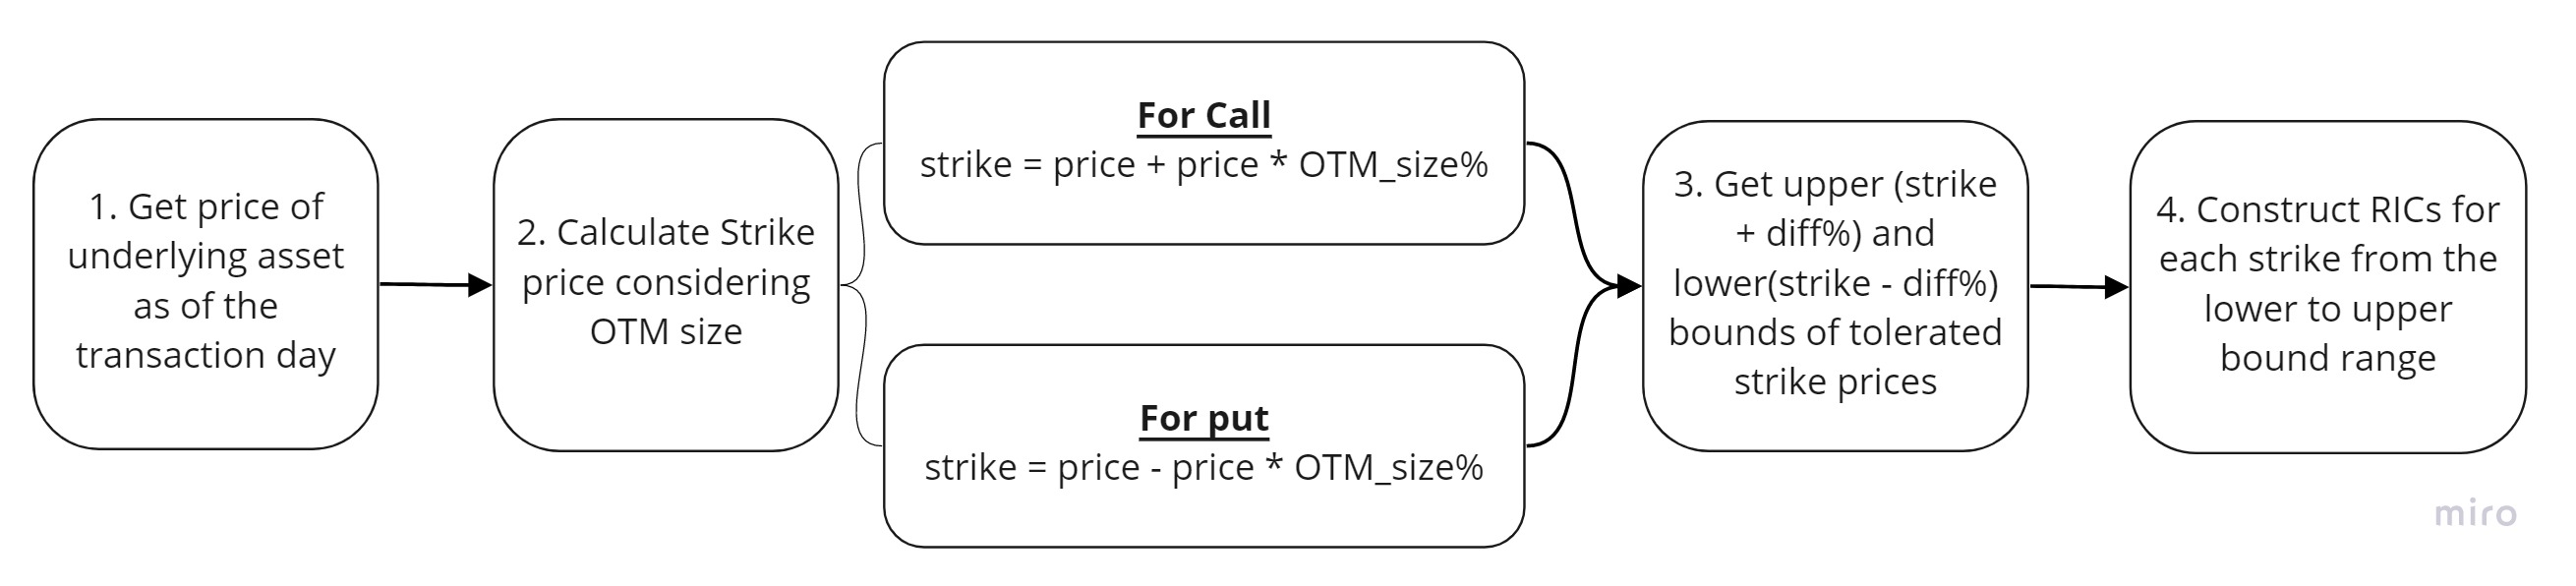

The function works for both indices and equities. The exact RIC codes (e.g ".NDX" or 'MSFT.O') for each asset needs to be given to the function. Further the function trims the necessary part of the asset RIC for option RIC construction. The rest of the details on constructing each component of option RIC is explained inside the code as comments.

After the code is fully executed, we report the logs in a text file.

In [6]:
def get_potential_rics(year, trans_day, asset, OTM_size, diff, opt_type):
    '''
    This functions returns the list of potential option RICs for a specified year reconstructed based on Refinitiv RIC and option trading rules.
    --------------------------------------
    Input:
        year (int): Year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'exp' indicating first or expiration day of a month respectively
        asset (str): RIC code of the asset
        OTM_size (int): percentage number indicating how far away is the strike price from the price of underlying asset
        diff (int): Tolarated difference in OTM to contruct upper and lower bound of strike prices
        opt_type (str): takes either "call" or "put"
    Output:
        potential_RICs (dict): dictionary containing potential RICs for each month with strike prices from the lower to upper bound of strikes
        strikes (list): list of strike prices calculayed based on OTM size for each month
    ''' 
    # open file to report log of function output
    report = open("Log report.txt", "a")
    
    # call functions to get expiration and transaction days
    trans_days = get_trans_days(year, trans_day)
    trans_days_prev = get_trans_days(year-1, trans_day)
    dates = get_exp_dates(year) 

    # trim underlying assets RIC to get the required part for option RIC
    if asset[0] == '.': #we remove "." symbol for index option
        asset_name = asset[1:]
    else:
        asset_name = asset.split('.')[0] #we need only first part of RICs for equities
        
    # define expiration month codes to be used after "^" sign
    exp = ['A', 'B', 'C', 'D','E','F','G', 'H', 'I', 'J', 'K', 'L']
    potential_RICs = {}
    strikes = []
    
    # construct potential RICs for each month of a specified year
    for j in range(1,13):
        # get day of expiration for a month
        day = dates[year][j-1]
        
        # get date of price request, which is in the previous month of expiration 
        if j != 1: 
            date = str(year) + '-' + str(j-1) + '-' + str(trans_days[j-2])
        if j == 1: #for January, we need to subtact year along with the month
            date = str(year-1) + '-' + str(j+11) + '-' + str(trans_days_prev[j+10])    
        # get price of underlying asset as of transaction date
        price, err = rdp.legacy.get_data(asset, fields = ['TR.PriceClose'], parameters = {'SDate': date})
        price = price.iloc[0,1]
        
        # calculate strike price for call options
        if opt_type == 'call':
            strike = price + price * OTM_size/100
            # define expiration month codes for call options while also considering the strike price
            if strike > 999.999:
                exp_codes_call = ['a', 'b', 'c', 'd','e','f','g', 'h', 'i', 'j', 'k', 'l']
            else:
                exp_codes_call = ['A', 'B', 'C', 'D','E','F','G', 'H', 'I', 'J', 'K', 'L']
            # get exp month code for a month
            exp_month = exp_codes_call[j-1]
            
        # calculate strike price and get exp month code for a month for pur options
        elif opt_type == 'put':
            strike = price - price * OTM_size/100
            if strike > 999.999:
                exp_codes_put = ['m', 'n', 'o', 'p','q','r','s', 't', 'u', 'v', 'w', 'x'] 
            else:
                exp_codes_put = ['M', 'N', 'O', 'P','Q','R','S', 'T', 'U', 'V', 'W', 'X']
            exp_month = exp_codes_put[j-1]
            
        strikes.append(int(round(strike,0))) # append calculated strike price to list of strikes
        
        # calculate lower and upper bound for strikes considering the value of strike
        if strike > 999.999:
            step = 5 # we loop over strikes with a step 5 for larger strikes
            strike_ub = int(round((strike + strike*diff/100),-1))
            strike_lb = int(round((strike - strike*diff/100),-1))
        else:
            step = 1 # we loop over strikes with a step 1 for smaler strikes
            strike_ub = int(strike + strike*diff/100)
            strike_lb = int(strike - strike*diff/100)
        
        # construct RICs for each strike from the lower to upper bound range of strikes
        for n in range(strike_lb, strike_ub + step, step):
            k = None # for strikes < 1000 along with 1 step increment changes in strikes we do 0.5 point increment changes which 
                     #allows to consider strikes with decimal points. This is important to get closer OTMs for smaller valued assets.
            # here we construct option RICs by adding together the all of the RIC components
            # Please note some of the components are different depending on the strike value
            if n < 10:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + '00' + str(n) + '00.U^' + exp[j-1] + str(year)[-2:]# for integer steps
                k = asset_name + exp_month + str(day) + str(year)[-2:] + '00' + str(n) + '50.U^' + exp[j-1] + str(year)[-2:]# for decimal steps
            elif n >= 10 and n < 100:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + '0' + str(n) + '00.U^' + exp[j-1] + str(year)[-2:]
                k = asset_name + exp_month + str(day) + str(year)[-2:] + '0' + str(n) + '50.U^' + exp[j-1] + str(year)[-2:]
            if n >= 100 and n < 1000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + str(n) + '00.U^' + exp[j-1] + str(year)[-2:]   
                k = asset_name + exp_month + str(day) + str(year)[-2:] + str(n) + '50.U^' + exp[j-1] + str(year)[-2:]
            elif n >= 1000 and n < 10000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + str(n) + '0.U^' + exp[j-1] + str(year)[-2:]
            elif n >= 10000 and n < 20000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + 'A' + str(n)[-4:] + '.U^' + exp[j-1] + str(year)[-2:]
            elif n >= 20000 and n < 30000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + 'B' + str(n)[-4:] + '.U^' + exp[j-1] + str(year)[-2:]
            elif n >= 30000 and n < 40000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + 'C' + str(n)[-4:] + '.U^' + exp[j-1] + str(year)[-2:]
            elif n >= 40000 and n < 50000:
                z = asset_name + exp_month + str(day) + str(year)[-2:] + 'D' + str(n)[-4:] + '.U^' + exp[j-1] + str(year)[-2:]
            
            # append RICs with integer strikes to the dictionary
            if j in potential_RICs:
                potential_RICs[j].append(z)
                # append RICs with decimal point strikes to the dictionary
                if k is not None:
                    potential_RICs[j].append(k)
            else:
                potential_RICs[j] = [z]
                if k is not None:
                    potential_RICs[j].append(k)  
                    
    # report funtion results and close log file
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: Potential RICs for {opt_type} options with {OTM_size}% OTM for {year} are constructed\n')
    report.close()
    return potential_RICs, strikes

Below we run the function to showcase the ouput for call option from 2020 with 10% OTM and 0.5% tolerance.

In [11]:
call_RICs, call_strikes = get_potential_rics(2020, 'first','.NDX', 10, 0.5, 'call')
print(call_RICs)

{1: ['NDXa172090900.U^A20', 'NDXa172090950.U^A20', 'NDXa172091000.U^A20', 'NDXa172091050.U^A20', 'NDXa172091100.U^A20', 'NDXa172091150.U^A20', 'NDXa172091200.U^A20', 'NDXa172091250.U^A20', 'NDXa172091300.U^A20', 'NDXa172091350.U^A20', 'NDXa172091400.U^A20', 'NDXa172091450.U^A20', 'NDXa172091500.U^A20', 'NDXa172091550.U^A20', 'NDXa172091600.U^A20', 'NDXa172091650.U^A20', 'NDXa172091700.U^A20', 'NDXa172091750.U^A20', 'NDXa172091800.U^A20', 'NDXa172091850.U^A20', 'NDXa172091900.U^A20'], 2: ['NDXb212097100.U^B20', 'NDXb212097150.U^B20', 'NDXb212097200.U^B20', 'NDXb212097250.U^B20', 'NDXb212097300.U^B20', 'NDXb212097350.U^B20', 'NDXb212097400.U^B20', 'NDXb212097450.U^B20', 'NDXb212097500.U^B20', 'NDXb212097550.U^B20', 'NDXb212097600.U^B20', 'NDXb212097650.U^B20', 'NDXb212097700.U^B20', 'NDXb212097750.U^B20', 'NDXb212097800.U^B20', 'NDXb212097850.U^B20', 'NDXb212097900.U^B20', 'NDXb212097950.U^B20', 'NDXb212098000.U^B20', 'NDXb212098050.U^B20', 'NDXb212098100.U^B20'], 3: ['NDXc202099900.U^C2

The output from the function get_potential_rics lists the RICs for each month with strike prices from the range lower to upper bound of strikes. In order to make sure we are trading the option with a strike price closest to the specified OTM price we need to sort the RICs of each month in an order of closeseness of option contract strike price with OTM price. The function below takes potential RICs and strike prices (OTM calculated) as an input and returns the sorted dictionary of RICs. 

In [7]:
def sort_option(pot_RICs, strikes):
    '''
    This functions sorts the potential RICs in an order of closeseness of option contract strike price with underlying price with given OTM.
    --------------------------------------
    Input:
        pot_RICs (dict): dictionary containing potential RICs for each month with strike prices from the lower to upper bound of strikes
        strikes (list): list of strike prices calculayed based on OTM size for each month 
    Output:
        pot_RICs (dict): dictionary containing potential RICs for each month sortedin an order of closeseness of option contract strike price with underlying price with given OTM
    '''
    i = -1
    # loop over each month
    for month in pot_RICs:
        i += 1
        # loop over each RIC per month
        for RIC in pot_RICs[month]:
            # calculate the absolute difference of option strike price and the strike price calculated based on specified OTM size
            sort = [abs(int(RIC[-11:-7]) - int((str(strikes[i])[-4:]+ '0')[:4])) if RIC[-11] != 'A' else 
                    abs(int(RIC[-10:-6]) - int(str(strikes[i])[-4:])) for RIC in pot_RICs[month]]
            # sort original dictionary with the sort order
            pot_RICs[month] = [month_sorted for _, month_sorted in sorted(zip(sort, pot_RICs[month]))]
    return pot_RICs

Below we run the function to showcase the sorted output.

In [13]:
call_sorted = sort_option(call_RICs,  call_strikes)
print(call_sorted)

{1: ['NDXa172091400.U^A20', 'NDXa172091350.U^A20', 'NDXa172091450.U^A20', 'NDXa172091300.U^A20', 'NDXa172091500.U^A20', 'NDXa172091250.U^A20', 'NDXa172091550.U^A20', 'NDXa172091200.U^A20', 'NDXa172091600.U^A20', 'NDXa172091150.U^A20', 'NDXa172091650.U^A20', 'NDXa172091100.U^A20', 'NDXa172091700.U^A20', 'NDXa172091050.U^A20', 'NDXa172091750.U^A20', 'NDXa172091000.U^A20', 'NDXa172091800.U^A20', 'NDXa172090950.U^A20', 'NDXa172091850.U^A20', 'NDXa172090900.U^A20', 'NDXa172091900.U^A20'], 2: ['NDXb212097600.U^B20', 'NDXb212097550.U^B20', 'NDXb212097650.U^B20', 'NDXb212097500.U^B20', 'NDXb212097700.U^B20', 'NDXb212097450.U^B20', 'NDXb212097750.U^B20', 'NDXb212097400.U^B20', 'NDXb212097800.U^B20', 'NDXb212097350.U^B20', 'NDXb212097850.U^B20', 'NDXb212097300.U^B20', 'NDXb212097900.U^B20', 'NDXb212097250.U^B20', 'NDXb212097950.U^B20', 'NDXb212097200.U^B20', 'NDXb212098000.U^B20', 'NDXb212097150.U^B20', 'NDXb212098050.U^B20', 'NDXb212097100.U^B20', 'NDXb212098100.U^B20'], 3: ['NDXc2020A0040.U^C2

#### 1.4 Function to validate potential RICs

As the name of the get_potential_rics function indicates, it produces list of potential RICs part of which (sometimes all, if you request for higher OTMs for illiquid option contract) is not an actual RIC. In order to validate them, we need to make API calls. Here we use **get_historical_price_summaries** from RDP API which results None if the RIC is invalid, otherwise it returns the values from the specified fields. One may you **get_date** from Eikon API, however it returns error if the RIC is invalid and you may need to write try/except loop and hide the errors/warnings. 

It should be noted that the function mentioned below should be **used only** if one wants to **validate all RICs** from the list of potential RICs. As a rule, in option strategy backtestings when you found a valid RIC for a month, you don't have to test other RICs of that month as you have already traded one. In our example, to test short iron condor strategy, we don't call this function, instead we check the validity of a RIC right inside the transaction function (see function **trans_option**) to avoid extensive API requests and hitting the daily limit of 10000 requests.

In [8]:
def get_valid_rics(year, trans_day, pot_RICs_sorted):
    '''
    This functions checks the validity of a RIC by making API calls and returns dictionary of valid RICs per month at a specified year. 
    --------------------------------------
    Input:
        year (int): Year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'exp' indicating first or expiration day of a month respectively
        pot_RICs_sorted (dict): dictionary containing potential RICs which are already sorted
    Output:
        valid_rics (dict): dictionary containing validated RICs for each month
    '''
    report = open("Log report.txt", "a")
    
    trans_days = get_trans_days(year, trans_day)
    dates = get_exp_dates(year)
    trans_days_prev = get_trans_days(year-1, trans_day)
    valid_rics = {}
    
    # get start and end date of the api requests
    for month in pot_RICs_sorted:
        edate = str(year) + '-' + str(month) + '-' + str(dates[year][month-1])
        if month > 1:
            sdate = str(year) + '-' + str(month-1) + '-' + str(trans_days[month-2])
        if month == 1:
            sdate = str(year-1) + '-' + str(month+11) + '-' + str(trans_days_prev[month+10])
        
        # make an API call for each RIC for each month
        for RIC in pot_RICs_sorted[month]:
            vals = rdp.get_historical_price_summaries(RIC,  start = sdate, end = edate, interval = rdp.Intervals.DAILY,
                                                        fields = ['BID','ASK','TRDPRC_1'])  
            # add valid RICs to a dictionary
            if vals is not None:
                vals.reset_index(inplace = True)
                if month in valid_rics:
                    valid_rics[month].append(RIC)
                else:
                    valid_rics[month] = [RIC]
                    
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: Valid RICs with specified criteria for {len(valid_rics)} month during {year} are found\n')
    report.close()
    return valid_rics

Below we run the function to showcase the valid RICs.

In [33]:
valid_rics_call = get_valid_rics(2020,'first', call_sorted)
print(valid_rics_call)

{1: ['NDXa172091400.U^A20', 'NDXa172091300.U^A20', 'NDXa172091500.U^A20', 'NDXa172091250.U^A20', 'NDXa172091200.U^A20', 'NDXa172091600.U^A20', 'NDXa172091100.U^A20', 'NDXa172091700.U^A20', 'NDXa172091750.U^A20', 'NDXa172091000.U^A20', 'NDXa172091800.U^A20', 'NDXa172090900.U^A20', 'NDXa172091900.U^A20'], 2: ['NDXb212097600.U^B20', 'NDXb212097500.U^B20', 'NDXb212097700.U^B20', 'NDXb212097750.U^B20', 'NDXb212097400.U^B20', 'NDXb212097800.U^B20', 'NDXb212097300.U^B20', 'NDXb212097900.U^B20', 'NDXb212097250.U^B20', 'NDXb212097200.U^B20', 'NDXb212098000.U^B20', 'NDXb212097100.U^B20', 'NDXb212098100.U^B20'], 3: ['NDXc2020A0040.U^C20', 'NDXc2020A0030.U^C20', 'NDXc2020A0050.U^C20', 'NDXc2020A0025.U^C20', 'NDXc2020A0020.U^C20', 'NDXc2020A0060.U^C20', 'NDXc2020A0010.U^C20', 'NDXc2020A0070.U^C20', 'NDXc2020A0075.U^C20', 'NDXc2020A0000.U^C20', 'NDXc2020A0080.U^C20', 'NDXc2020A0090.U^C20', 'NDXc202099900.U^C20'], 4: ['NDXd172097750.U^D20', 'NDXd172097500.U^D20', 'NDXd172098000.U^D20', 'NDXd172097250

## Section 2: Option transactions and strategy outcome

After we have the list of potential RICs for each month, we trade them by taking long or short positions for a contract every month of a given year. The **trans_option** function takes year, transaction day ("first" or "exp"), asset name, potential sorted RICs, option type and position ("short" or "long") and returns a dataframe consisting of transaction details.

Here should be additionally stated, that the function works by the potential RICs and one don't have to run the function **get_valid_rics**. This function takes the first RIC from the month (which is already sorted having the ones we want at the begining) and checks the validity by requesting  Trade, BID and ASK prices through RDP **get_historical_price_summaries**. If valid, the prices are considered for the trade, if not, the next RIC is tried. This continues until the point when a valid RIC with a valid option contract price (see) is found for a month. If no valid RIC is found for a month, no option contract is traded for that month, which is reported in Log file accordingly. As it comes to valid option contract price, it is considered to be one of the following (in an order as provided below):

**a.** Trade price
   
**b.** BID/ASK mid price
   
**c.** ASK price minus average bid/ask spread for the period
   
**d.** BID price plus average bid/ask spread for the period
   
**e.** ASK price
   
**f.** BID price

In order to get more values for more robust estimate of option contract price, we request price data from 2 month before the transaction date. Transaction date is either first business day or the expiration day every month, which needs to be specified as function parameter. Options expire in the expiration cycle of the following month of the purchase.

The rest of the details on building a dataframe of transaction details is explained inside the code as comments.

After the code is fully executed we report the logs in a text file.

#### 2.1 Function to create option positions

In [9]:
def trans_option(year, trans_day, asset, RICs, opt_type, position):
    '''
    This functions registers the option contract buy/sell transaction for each month in a given year along with other transaction details,
    such as Strike price, underlying price, actual OTM size etc.  
    --------------------------------------
    Input:
        year (int): Year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'exp' indicating first or expiration day of a month respectively
        asset (str): RIC code of the asset
        RICs (dict): dictionary containing potential RICs which are already sorted
        opt_type (str): takes either "call" or "put"
        position (str): takes either "short" or "long"
    Output:
        trans_details (DataFrame): Pandas DataFrame containing transaction details
    '''         
    report = open("Log report.txt", "a")
    trans_days = get_trans_days(year, trans_day)
    dates = get_exp_dates(year)
    trans_days_prev = get_trans_days(year-1, trans_day)
    
    # create empty disctionary with transaction details as keys
    trans_details = {'RIC':[],'Trans_Date':[],'Exp_date': [],'Option type':[], 'Position':[], 'Strike':[], 'Price_Trans_Date': [], 'Option Price':[], 'OTM size': []}
    
    for month in RICs:
        for RIC in RICs[month]:
            # get start and end date of the api requests
            edate = str(year) + '-' + str(month) + '-' + str(dates[year][month-1])
            if month > 2:
                sdate = str(year) + '-' + str(month-1) + '-' + str(trans_days[month-2])
                sdate_req = str(year) + '-' + str(month-2) + '-' + str(trans_days[month-3]) # we request 2 month before the trans days for option contract prices 
            if month == 1:
                sdate = str(year-1) + '-' + str(month+11) + '-' + str(trans_days_prev[month+10])
                sdate_req = str(year-1) + '-' + str(month+10) + '-' + str(trans_days_prev[month-4])
            if month == 2:
                sdate = str(year) + '-' + str(month-1) + '-' + str(trans_days[month-2])
                sdate_req = str(year-1) + '-' + str(month+10) + '-' + str(trans_days_prev[month-4])
            
            # request option contract prices
            vals = rdp.get_historical_price_summaries(RIC,  start = sdate_req, end = edate, interval = rdp.Intervals.DAILY,
                                                        fields = ['BID','ASK','TRDPRC_1'])     
            
            # check validity of a RIC and if valid register the transaction details
            if vals is not None:
                vals.reset_index(inplace = True)
                # get the best price for option contract trade with an order as sepcified in the cell above
                if vals.loc[vals['index'] == sdate].shape[0] == 1:
                    if len(vals['TRDPRC_1'].loc[vals['index'] == sdate]) == 1 and vals['TRDPRC_1'].loc[vals['index'] == sdate].notna().any():
                        price = vals['TRDPRC_1'].loc[vals['index'] == sdate].values[0]
                    elif (vals['ASK']).sum() == 0 and (vals['BID']).sum() != 0:
                        price = vals['BID'].loc[vals['index'] == sdate].values[0]  
                    elif (vals['ASK']).sum() != 0 and (vals['BID']).sum() == 0:
                        price = vals['ASK'].loc[vals['index'] == sdate].values[0]
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == True and vals['BID'].loc[vals['index'] == sdate].any() == True:
                        price = (vals['ASK'].loc[vals['index'] == sdate].values[0] + vals['BID'].loc[vals['index'] == sdate].values[0])/2
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == True and vals['BID'].loc[vals['index'] == sdate].any() == False:
                        av_spread = ((vals['ASK'] - vals['BID'])/vals['ASK']).mean()
                        price = vals['ASK'].loc[vals['index'] == sdate].values[0] - vals['ASK'].loc[vals['index'] == sdate].values[0]*av_spread
                    elif vals['ASK'].loc[vals['index'] == sdate].any() == False and vals['BID'].loc[vals['index'] == sdate].any() == True:
                        av_spread = ((vals['ASK'] - vals['BID'])/vals['BID']).mean()
                        price = vals['BID'].loc[vals['index'] == sdate].values[0] + vals['BID'].loc[vals['index'] == sdate].values[0]*av_spread  
                    
                    # if valid price is found register some of the transaction details
                    trans_details['Option Price'].append(round(float(price),2))
                    trans_details['Trans_Date'].append(vals['index'].loc[vals['index'] == sdate].values[0])
                    trans_details['Option type'].append(opt_type)
                    trans_details['Exp_date'].append(datetime.strptime(edate, '%Y-%m-%d'))
                    trans_details['RIC'].append(RIC)              
                    trans_details['Position'].append(position)
                    
                    # to construct strike price, calculate OTM size and add those (along with the price) to the transaction details 
                    #we need to request the underlying price as of the transaction date
                    prices = []                    
                    val, err = rdp.legacy.get_data(asset, fields = ['TR.PriceClose'], parameters = {'SDate': sdate})
                    price = val.iloc[0,1]
                    trans_details['Price_Trans_Date'].append(price)
                    
                    # get the integer and decimal parts of the strike price depending on the underlying asset price value
                    # for prices < 1000 we get both integer and decimal parts
                    # strikes are constructed according to RULES7
                    if price < 10:
                        int_part = int(RIC[-9:-8])
                        dec_part = RIC[-8:-6]
                        strike = float(int_part + '.' + dec_part)
                    elif price >= 10 and price < 100:
                        int_part = RIC[-10:-8]
                        dec_part = RIC[-8:-6]
                        strike = float(int_part + '.' + dec_part)
                    elif price >= 100 and price < 1000:
                        int_part = RIC[-11:-8]
                        dec_part = RIC[-8:-6]
                        strike = float(int_part + '.' + dec_part)
                    elif price >= 1000 and price < 10000:
                        if RIC[-11] == 'A': # sometimes when underlying price is closer to 10000, the strike with OTM size falls in the range of >10000
                            strike = float(RIC[-11:-6].replace('A', "1"))
                        else:
                            strike = float(RIC[-11:-7])
                    elif price >= 10000 and price < 20000:
                        if RIC[-11] == 'A':
                            strike = float(RIC[-11:-6].replace('A', "1"))
                        else: # sometimes when underlying price is closer to 10000, the strike with OTM size falls in the range of <10000
                            strike = float(RIC[-11:-7]) 
                    elif price >= 20000 and price < 30000:
                        strike = float(RIC[-11:-6].replace('B', "2"))
                    elif price >= 30000 and price < 40000:
                        strike = float(RIC[-11:-6].replace('C', "3"))
                    elif price >= 40000 and price < 50000:
                        strike = float(RIC[-11:-6].replace('D', "4"))
                    trans_details['Strike'].append(strike)
                    
                    # calculate and register actual OTM size
                    if opt_type == 'call':
                        OTM = round((strike - price)/price*100, 2)
                    elif opt_type == 'put':
                        OTM = round((price - strike)/price*100, 2)  
                    trans_details['OTM size'].append(OTM)
                    break # stop the loop if an option contract is traded and all transaction details are added
                    
        # check if an option contract is purchased for a month and report if not
        if datetime.strptime(edate, '%Y-%m-%d') not in trans_details['Exp_date']:
            now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
            report.write(f'{now}: No {opt_type} option is purchased for month {month}\n')
    
    # report total number of transactions during a year
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: {len(pd.DataFrame(trans_details))} {position} {opt_type} transactions for {year} are registered\n')
    report.close()
    return pd.DataFrame(trans_details)

Below we run the function to showcase the resulting dataframe of transaction output. Explanation follows the dataframe table.

In [15]:
call_trans = trans_option(2020,'first', '.NDX', call_sorted, 'call', 'short')
call_trans

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size
0,NDXa172091500.U^A20,2019-12-02,2020-01-17,call,short,9150.0,8309.260,1.18,10.12
1,NDXb212098000.U^B20,2020-01-02,2020-02-21,call,short,9800.0,8872.219,1.83,10.46
2,NDXc2020A0000.U^C20,2020-02-03,2020-03-20,call,short,10000.0,9126.232,2.77,9.57
3,NDXd172097750.U^D20,2020-03-02,2020-04-17,call,short,9775.0,8877.978,15.45,10.10
4,NDXe152082500.U^E20,2020-04-01,2020-05-15,call,short,8250.0,7486.287,135.10,10.20
5,NDXf192096000.U^F20,2020-05-01,2020-06-19,call,short,9600.0,8718.179,66.20,10.11
6,NDXg1720A0550.U^G20,2020-06-01,2020-07-17,call,short,10550.0,9598.887,22.85,9.91
7,NDXh2120A1300.U^H20,2020-07-01,2020-08-21,call,short,11300.0,10279.248,40.10,9.93
8,NDXi1820A2150.U^I20,2020-08-03,2020-09-18,call,short,12150.0,11055.076,38.15,9.90
9,NDXj1620A3500.U^J20,2020-09-01,2020-10-16,call,short,13500.0,12292.863,111.50,9.82


As we can see above, the resulting dataframe consist of the following transaction details:

* **RIC** - Option RIC with a strike price closest to the strike calculated based on OTM size (e.g. for call option: strike = price + price*OTM/100)
* **Trans_Date** - Transaction date, which is either first business day or expiration day of a month based on a parameter trans_day
* **Exp_Date** - Expiration day of an option contract, which is the 3rd Friday of each month for OPRA exchange traded monthly options with AM settlement
* **Option Type** - Call or Put as specified in function parameter
* **Position** - Long or Short as specified n function parameter
* **Strike** - Strike price of the traded option contract. This is retrieved based on underlying asset price value and in accordance with RULES7
* **Price_trans_Date** - Price of underlying asset at the transaction date
* **Option Price** - Price of teh option contract retrieved/calculated based on the consideration from the cell above
* **OTM size** - The actual size of OTM, calculated based on underlying asset price and strike of the traded option contract

As option strategies are mostly done by pairs we created a separate **pair_trans** function which conducts paired transactions by calling **get_potential_rics**, **sort_option**, and **trans_option** function for call and put options with specified parameter values. This function takes year, trans_day, asset name, OTM sizes and positions for call and put options and returns transaction details for both call and put option trades.

In [10]:
def pair_trans(year, trans_day, asset, call_OTM, put_OTM, diff, call_pos, put_pos):
    '''
    This functions implements option pair transaction by calling some of the abovementioned functions for call/put pair.
    --------------------------------------
    Input:
        year (int): Year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'exp' indicating first or expiration day of a month respectively
        asset (str): RIC code of the asset
        RICs (dict): dictionary containing potential RICs which are already sorted
        call_OTM (int): OTM size for Call option
        put_OTM (int): OTM size for Put option
        diff (int): Tolarated difference in actual OTM size
        call_pos (str): Trade position for call option. Takes either "short" or "long"
        put_pos (str): Trade position for put option. Takes either "short" or "long"

    Output:
        call_trans (DataFrame): Pandas DataFrame containing transaction details for call options
        put_trans (DataFrame): Pandas DataFrame containing transaction details for put options
    '''  
    # request functions for call options
    call_RICs, call_strikes = get_potential_rics(year, trans_day, asset, call_OTM, diff, 'call')
    call_sorted = sort_option(call_RICs, call_strikes)
    call_trans = trans_option(year, trans_day, asset, call_sorted, 'call', call_pos)

    # request functions for put options
    put_RICs, put_strikes = get_potential_rics(year, trans_day, asset, put_OTM, diff, 'put')
    put_sorted = sort_option(put_RICs, put_strikes)
    put_trans = trans_option(year, trans_day, asset, put_sorted, 'put', put_pos)
    
    # join put and call transactions
    trans = pd.concat([call_trans, put_trans]).reset_index()
    trans.drop(columns = ['index'], inplace=True)
    trans = trans.sort_values(by=['Exp_date'])

    return trans

Below we run the function to showcase the resulting dataframe of transaction outputs.

In [21]:
trans = pair_trans(2020, 'first', '.NDX', 10, 20, 2, 'short', 'long')

In [104]:
trans

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size
0,NDXa172091500.U^A20,2019-12-02,2020-01-17,call,short,9150.0,8309.260,1.18,10.12
12,NDXm172066500.U^A20,2019-12-02,2020-01-17,put,long,6650.0,8309.260,6.45,19.97
1,NDXb212098000.U^B20,2020-01-02,2020-02-21,call,short,9800.0,8872.219,1.83,10.46
13,NDXn212071000.U^B20,2020-01-02,2020-02-21,put,long,7100.0,8872.219,8.10,19.97
2,NDXc2020A0000.U^C20,2020-02-03,2020-03-20,call,short,10000.0,9126.232,2.77,9.57
14,NDXo202073000.U^C20,2020-02-03,2020-03-20,put,long,7300.0,9126.232,12.70,20.01
3,NDXd172097750.U^D20,2020-03-02,2020-04-17,call,short,9775.0,8877.978,15.45,10.10
15,NDXp172071000.U^D20,2020-03-02,2020-04-17,put,long,7100.0,8877.978,62.50,20.03
4,NDXe152082500.U^E20,2020-04-01,2020-05-15,call,short,8250.0,7486.287,135.10,10.20
16,NDXq152060000.U^E20,2020-04-01,2020-05-15,put,long,6000.0,7486.287,102.50,19.85


#### 2.2 Function to offset positions

In option trading strategies one won't open positions and wait until the expiration day to register the strategy outcome. Most of the time, traders use offset models which create triggers for closing the open positions and registering outcome as of the position close day. Traders use  sophisticated models for determinizing offset triggers, however, the aim of this article is not suggesting the best model for that, but rather showcase how Refinitiv APIs can be use for option strategy backtestinging, which would support both opening and closing of the positions. Thus, in this article we base our offset strategy on [CBOE Volatility index (VIX)](https://www.investopedia.com/terms/v/vix.asp). 

Particularly, we first create a threshold which is equal to 2 standard deviation of previous 30 days VIX change. Then we calculate 3 day moving average (MA) of VIX and track MA change after the transaction date. If the MA exceeds the threshold at any point after the position is open, we create an offset transaction, which is short RICs with long position and long the ones with short positions. Usage of MA, instead of actual VIX change makes price movements smoother allowing to avoid False Alarms and threshold based on previous periods standard deviations allows to adapt to the changing market conditions.

The **exit_trans** function takes call and put option transactions as an input and returns a dataframe containing the offset transactions. To conduct offset transactions, the function first requests VIX data from RDP **get_historical_price_summaries** for each transaction date of inputted option transactions. Request period is from 30 dates before the transaction to expiration date of respective option contract. Then based on the VIX trade price, function calculates VIX change and the MA (including the change). Finally threshold for that month is calculated. Then, the functions loops over all days following the position open date and if the MA change for a day exceeds the threshold, offset transaction date is fixed and historical price summaries are requested for respective option contracts, both put and call. The considerations described for option contract price retrieval/calculations above are applied for offset transactions as well. After all transaction details are knows, those are appended to transaction dictionary.
The rest of the details on building a dataframe of transaction details is explained inside the code as comments.

After the code is fully executed we report the logs in a text file.

In [11]:
def exit_trans(option_trans):
    '''
    This functions creates offset transactions after a trigger happens. 
    --------------------------------------
    Input:
        option_trans (DataFrame): Pandas DataFrame containing all option transactions, including call and put
    Output:
        exit_trans (DataFrame): Pandas DataFrame containing all offset transactions, including call and put
    '''    
    report = open("Log report.txt", "a")
    exit_dict = {'RIC':[],'Trans_Date':[],'Exp_date': [],'Option type':[], 'Position':[], 'Strike':[], 'Price_Trans_Date': [], 'Option Price':[], 'OTM size': []}
    
    for date in option_trans['Trans_Date'].unique():
        # get start and end dates for VIX api request
        sdate = pd.to_datetime(str(date - np.timedelta64(1,'D'))).strftime('%Y-%m-%d')
        sdate_req = pd.to_datetime(str(date - np.timedelta64(30,'D'))).strftime('%Y-%m-%d')
        date = pd.to_datetime(str(date)).strftime('%Y-%m-%d')
        index = option_trans.loc[option_trans['Trans_Date'] == date].index
        edate = pd.to_datetime(str(option_trans['Exp_date'][index[0]])).strftime('%Y-%m-%d')
        edate_1 = pd.to_datetime(str(option_trans['Exp_date'][index[0]]- np.timedelta64(1,'D'))).strftime('%Y-%m-%d') # we don't consider the expiration day
        
        # request VIX trade price details for a specified period
        vix = rdp.get_historical_price_summaries('.VIX',  start = sdate_req, end = edate_1,
                                                 fields = ['TRDPRC_1'], interval = rdp.Intervals.DAILY).astype(float)
        # calculate VIX price chanes
        vix["VIX_change"] = vix['TRDPRC_1'].pct_change()*100
        vix.reset_index(inplace = True)
        
        # calculate 3 day MA of VIX price
        vix_pr = vix['TRDPRC_1'].to_numpy()
        vix['ma'] = moving_average(vix_pr, 3) # we call external function for MA calculation
        vix["ma_change"] = vix['ma'].pct_change()*100  # calculate MA change
        
        # calculate threshold for a transaction date
        thresh = vix['VIX_change'].loc[vix['index'] < date].std() * 2
        
        for day in vix.loc[vix['index'] > date]['index']:
            # check if MA exceeds the threshold for a day following the position opening date
            if vix['ma_change'].loc[vix['index'] == day].values > thresh:
                # if yes, fix the date when trigger happened and get start and end date of option contract price request
                vix_date = vix['index'].loc[vix['index'] == day].values
                sdate = pd.to_datetime(str(vix_date[0] - np.timedelta64(30,'D'))).strftime('%Y-%m-%d')
                edate = pd.to_datetime(str(vix_date[0] + np.timedelta64(1,'D'))).strftime('%Y-%m-%d')
                
                # request option contract price for both call and put option positions opened on a transaction date
                for idx in index:
                    RIC = option_trans['RIC'][idx]
                    prices = rdp.get_historical_price_summaries(RIC,  start = str(sdate), end = str(edate), interval = rdp.Intervals.DAILY,
                                                                    fields = ['BID','ASK','TRDPRC_1']).reset_index()
                    # get the best price for option contract trade with an order as sepcified in the above section
                    if len(prices['TRDPRC_1'].loc[prices['index'] == vix_date[0]]) == 1 and prices['TRDPRC_1'].loc[prices['index'] == vix_date[0]].notna().any():
                        price = prices['TRDPRC_1'].loc[prices['index'] == vix_date[0]].values[0]
                    elif (prices['ASK']).sum() == 0 and (prices['BID']).sum() != 0:
                        price = prices['BID'].loc[prices['index'] == vix_date[0]].values[0]
                    elif (prices['ASK']).sum() != 0 and (prices['BID']).sum() == 0:
                        price = prices['ASK'].loc[prices['index'] == vix_date[0]].values[0]
                    elif prices['ASK'].loc[prices['index'] == vix_date[0]].any() == True and prices['BID'].loc[prices['index'] == vix_date[0]].any() == True:
                        price = (prices['ASK'].loc[prices['index'] == vix_date[0]].values[0] + prices['BID'].loc[prices['index'] == vix_date[0]].values[0])/2
                    elif prices['ASK'].loc[prices['index'] == vix_date[0]].any() == True and prices['BID'].loc[prices['index'] == vix_date[0]].any() == False:
                        av_spread = ((prices['ASK'] - prices['BID'])/prices['ASK']).mean()
                        price = prices['ASK'].loc[prices['index'] == vix_date[0]].values[0] - prices['ASK'].loc[prices['index'] == vix_date[0]].values[0]*av_spread
                    elif prices['ASK'].loc[prices['index'] == vix_date[0]].any() == False and prices['BID'].loc[prices['index'] == vix_date[0]].any() == True:
                        av_spread = ((prices['ASK'] - prices['BID'])/prices['BID']).mean()
                        price = prices['BID'].loc[prices['index'] == vix_date[0]].values[0] + prices['BID'].loc[prices['index'] == vix_date[0]].values[0]*av_spread  
                    else:
                        break # stop the loop if there is no appropriate price 
                    
                    # if valid price is found register the offset transaction details
                    exit_dict['RIC'].append(RIC)
                    exit_dict['Trans_Date'].append(vix_date[0])
                    exit_dict['Exp_date'].append(option_trans['Exp_date'][idx])
                    exit_dict['Option type'].append(option_trans['Option type'][idx])
                    if option_trans['Position'][idx] == 'short':
                        exit_dict['Position'].append('long')
                    else:
                        exit_dict['Position'].append('short')
                    exit_dict['Strike'].append(option_trans['Strike'][idx])
                    exit_dict['Price_Trans_Date'].append(np.nan)
                    exit_dict['Option Price'].append((round(float(price),2))) 
                    exit_dict['OTM size'].append(np.nan)
                
                # report the transaction log
                now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
                report.write(f'{now}: Positions for option pair opened on {date} has been exited through offset transaction\n')
                break # stop the loop if offset transaction is registered
    report.close()
    exit_trans = pd.DataFrame(exit_dict)
    return exit_trans

Below we difine a function to calculate simple moving average, which is used inside the exit_trans function.

In [12]:
def moving_average(stock_price, n = 3):
    '''
    Calculates the n-day (possibly weighted) moving average for a given stock over time.
    Input:
        stock_price (ndarray): single column with the share prices over time for one stock up to the current day.
        n (int, default 7): period of the moving average (in days).
    Output:
        ma (ndarray): the n-day (possibly weighted) moving average of the share price over time.
    '''
    i = len(stock_price)
    ma_l = []
    # reverse loop over stock prices untill point n-1
    for i in range(len(stock_price), n - 1, -1):
        point = stock_price[(i - n) : i] #set ma calculation point range
        point_average = np.sum(point) / n #calculate point average
        ma_l.append(point_average) #append ma list with the average value
        
    #reverse loop over stock prices from n-1 to 0
    for i in range(n - 1, 0, - 1):
        point = stock_price[0 : i]
        point_average = np.sum(point) / i
        ma_l.append(point_average)
        
    #reverse the list to ensure consistency    
    ma_l.reverse()
    #convert ma list into an array
    ma = np.array(ma_l)

    return ma

In [105]:
offset_trans = exit_trans(trans)
offset_trans

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size
0,NDXa172091500.U^A20,2019-12-03,2020-01-17,call,long,9150.0,NaN,0.93,NaN
1,NDXm172066500.U^A20,2019-12-03,2020-01-17,put,short,6650.0,NaN,7.25,NaN
2,NDXb212098000.U^B20,2020-01-27,2020-02-21,call,long,9800.0,NaN,0.76,NaN
3,NDXn212071000.U^B20,2020-01-27,2020-02-21,put,short,7100.0,NaN,2.80,NaN
4,NDXc2020A0000.U^C20,2020-02-24,2020-03-20,call,long,10000.0,NaN,4.00,NaN
5,NDXo202073000.U^C20,2020-02-24,2020-03-20,put,short,7300.0,NaN,10.37,NaN
6,NDXr192069750.U^F20,2020-06-11,2020-06-19,put,short,6975.0,NaN,2.15,NaN
7,NDXf192096000.U^F20,2020-06-11,2020-06-19,call,long,9600.0,NaN,210.85,NaN
8,NDXs172076750.U^G20,2020-06-11,2020-07-17,put,short,7675.0,NaN,34.75,NaN
9,NDXg1720A0550.U^G20,2020-06-11,2020-07-17,call,long,10550.0,NaN,50.40,NaN


#### 2.3 Function to calculate and report the outcome of the strategy

After we have all transactions, we calculate the transactions outcome by calculating and summing ups profit/loss over all traded option contracts. For that we define function **trans_outcome** which takes option transactions, asset name and VIX consideration as an input and returns same option transactions dataframe by adding the outcome details, including contract price, exercise outcome and total profit/loss per option transaction. It should be noted that we don't need to run **exit_trans** before running this function, instead we decide through the parameter cons_vix either consider offsetting or not. 

Before running the calculation part, the function first checks if the respective pair exist in the transaction list. If doesn't we remove the unpaired option transaction and report in the log file. The rest of the details on calculating the transaction outcome is explained inside the code as comments as well as in the cells following the running of the code. 

After the code is fully executed, we report the logs in a text file. 

In [13]:
def trans_outcome(option_trans, asset, cons_vix = 'yes'):
    '''
    This functions summarizes the strategy outcome by calculating profit/loss of each trnsaction and the bundle.
    --------------------------------------
    Input:
        option_trans (DataFrame): Pandas DataFrame containing all option transactions, including call and put, open and offset
        asset (str): RIC code of the asset
        cons_vix (str, default = 'yes'): parameter to activate offseting. takes either yes or no
    Output:
        option_trans (DataFrame): Pandas DataFrame containing all transactions along with caculated outcomes
    ''' 
    report = open("Log report.txt", "a")
    
    for date in option_trans['Exp_date']:
        # check if option transaction pair exists and drop the unpaired transaction if not
        if option_trans[option_trans['Exp_date'] == date].shape[0] < 2:
            option_trans.drop(option_trans.loc[option_trans['Exp_date'] == date].index, inplace=True)
            now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
            report.write(f'{now}: Transations with {date} expiration date has been removed because of unavailble option pair\n')
    
    # call offset function, if not specified otherwise
    if cons_vix != 'no':
        offset_trans = exit_trans(option_trans)
        option_trans = pd.concat([option_trans, offset_trans]).sort_values(by=['Exp_date'])

    # option_trans.index = option_trans.index + 1
    
    # create lists to store transaction close dates and prices as of the close date 
    close_date = []
    prices_cdate = []
    # check if there is offset transacion for an option contract
    for RIC in option_trans['RIC']:
        # append expiration date for option contracts which are not offsetted
        if option_trans.loc[option_trans['RIC'] == RIC].shape[0] == 1:
            close_date.append(option_trans['Exp_date'].loc[option_trans['RIC'] == RIC].values[0])
        # append offset transaction date (bigger from two transaction dates) for option contracts which are offsetted
        elif option_trans.loc[option_trans['RIC'] == RIC].shape[0] == 2:
            close_date.append(np.max(option_trans['Trans_Date'].loc[option_trans['RIC'] == RIC].values))
            
    # append the list of close dates to the transaction dataframe        
    option_trans.insert(loc = len(option_trans.columns), column = 'Close_date', value = close_date)
    
    # for each close date get the price and append the list of close date prices to the transaction dataframe
    for date in option_trans['Close_date']:
        df, err = rdp.legacy.get_data(asset, fields = ['TR.PriceClose'] , parameters={'SDate': date.strftime('%Y-%m-%d')})
        prices_cdate.append(df.iloc[0,1])      
    option_trans.insert(loc = len(option_trans.columns), column = 'Close_date_prices', value = prices_cdate)
    
    # calculate and append option contract price by multpying option price by 100 and adding "+-" sign depending on the position
    option_trans.insert(loc = len(option_trans.columns), column = "Contract price", value = np.where(option_trans['Position'] == 'short', option_trans['Option Price']*100, -option_trans['Option Price']*100))
   
    # calculate and append exercise outcome which is 0, if the option is expired worthless
    option_trans.insert(loc = len(option_trans.columns), column = "Exercise outcome", value = 
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), 0,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), 0,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), (option_trans['Close_date_prices'] - option_trans['Strike'])*100,
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), -(option_trans['Close_date_prices'] -  option_trans['Strike'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), (option_trans['Strike'] - option_trans['Close_date_prices'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), -(option_trans['Strike'] - option_trans['Close_date_prices'])*100,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), 0,
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), 0, 'NA')))))))))
    
    # calculate and append total profit/loss by summing up contract price and exercise outcome
    option_trans.insert(loc = len(option_trans.columns), column = "Total Profit/Loss", value =  option_trans["Contract price"] + option_trans["Exercise outcome"].astype(float))
    
    # show textual transaction outcome for better readability
    option_trans.insert(loc = len(option_trans.columns), column = "Outcome", value = 
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Expired worthless",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Expired worthless",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'call') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] > option_trans['Close_date_prices']), "Exercised option",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'long') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Expired worthless",
        np.where((option_trans['Option type'] == 'put') & (option_trans['Position'] == 'short') & (option_trans['Strike'] < option_trans['Close_date_prices']), "Expired worthless", 'NA')))))))))
    
    now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
    report.write(f'{now}: {len(option_trans)} option transactions are conducted\n')
    report.close()
    return option_trans

Below we run the function to showcase the resulting dataframe of transaction outcomes. Explanation follows the dataframe table.

In [107]:
results = trans_outcome(trans, '.NDX', 'yes')
results.head()

,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size,Close_date,Close_date_prices,Contract price,Exercise outcome,Total Profit/Loss,Outcome
0,NDXa172091500.U^A20,2019-12-02,2020-01-17,call,short,9150.0,8309.260,1.18,10.12,2019-12-03,8254.737,118.0,0,118.0,Expired worthless
1,NDXm172066500.U^A20,2019-12-03,2020-01-17,put,short,6650.0,NaN,7.25,NaN,2019-12-03,8254.737,725.0,0,725.0,Expired worthless
0,NDXa172091500.U^A20,2019-12-03,2020-01-17,call,long,9150.0,NaN,0.93,NaN,2019-12-03,8254.737,-93.0,0,-93.0,Expired worthless
12,NDXm172066500.U^A20,2019-12-02,2020-01-17,put,long,6650.0,8309.260,6.45,19.97,2019-12-03,8254.737,-645.0,0,-645.0,Expired worthless
13,NDXn212071000.U^B20,2020-01-02,2020-02-21,put,long,7100.0,8872.219,8.10,19.97,2020-01-27,8952.178,-810.0,0,-810.0,Expired worthless


In addition to the columns from the original transaction dataframe the following outcome details are added:

* **Close_date** - transaction close date, which is expiration day for transaction which ate not offsite and offset day for transactions which are closed by offset transaction.
* **Close_date_prices** - underlying asset prices as of the close day. We use this to calculate exercise outcome.
* **Contract Price** - Contract price which equals to option price multiplied by 100 which is the option contract multiplier.
* **Exercise outcome** - shows the profit/loss from exercised options and equals to 0 if the option contract is expired worthless.
* **Total Profit/Loss** - shows aggregated profit/los from an option transaction and equals to sum of option contract and exercise outcome.
* **Outcome** - textual representation of whether option is exercised or expired worthless.

Below we show the aggregated profit during each month of 2020 grouped by the expiration date.

In [27]:
agg_prof = results.groupby(by = ['Exp_date'])['Total Profit/Loss'].sum().reset_index()
agg_prof

,Exp_date,Total Profit/Loss
0,2020-01-17,105.0
1,2020-02-21,-423.0
2,2020-03-20,-356.0
3,2020-04-17,-4705.0
4,2020-05-15,-87003.9
5,2020-06-19,-21265.0
6,2020-07-17,-2685.0
7,2020-08-21,-26721.4
8,2020-09-18,-440.0
9,2020-10-16,4780.0


Here should be noted that this is outcome for a paired transaction only and not for an option strategy. In the next section we implement short iron condor strategy and visualize the backtesting outcome during 2015-2021.

## Section 3: Implement and visualize short iron condor strategy outcome

In this section, we implement the actual short iron condor strategy with 10%/20% legs for options on NDX index. Short iron condor strategy aims to profit from low volatility. The maximum profit is equal to the net credit received from option contract prices, and this profit is realized if the stock price is equal to or between the strike prices of the short options at expiration. In this outcome, all options expire worthless and the net credit is kept as income. The maximum loss is equal to the difference between the strike prices of the long put spread (or short call spread) less the net credit received. More about short iron condor strategy can be found [here](https://www.fidelity.com/learning-center/investment-products/options/options-strategy-guide/short-iron-condor-spread). It should be mentioned that in the scope of current article transactions fees are not taken into consideration and equal to zero. The actual profit and loss are calculated based contract price differences and exercise outcomes

#### 3.1 Implement short iron condor strategy

In [ ]:
# create empty dataframe
short_IC10_20 = pd.DataFrame()

for d in range(2015, 2022):
    # call functions to get call short/put long pair leg
    option_trans10_20 = pair_trans(d, 'first',  '.NDX', 10, 20, 2, 'short', 'long')
    results10_20 = trans_outcome(option_trans10_20, '.NDX', 'yes')
    short_IC10_20 = short_IC10_20.append(results10_20)

    # call functions to get second long call/short put pair leg
    option_trans20_10 = pair_trans(d, 'first', '.NDX', 20, 10, 2, 'long', 'short')
    results20_10 = trans_outcome(option_trans20_10, '.NDX', 'yes')
    short_IC10_20 = short_IC10_20.append(results20_10)


We store the date in excel, which allow us to look at the results and visualizations anytime without running the entire code.

In [25]:
short_IC10_20.to_excel('short_IC10_20ndx1521.xlsx')

Here we visualize results from iron condor strategy with 10/20% OTM size for NDX. There are other datasets in the [GitHub](https://github.com/Refinitiv-API-Samples/Article.EikonAPI.RDP.Python.OptionStrategyBacktesting) folder which are retrieved by the codes above. The below mentioned codes could be easily adjusted to visualize that as well. 

In [43]:
# short_IC10_20 = pd.read_excel('short_IC10_20spx1521.xlsx')
# short_IC10_20 = pd.read_excel('short_IC_10_20ndx1521.xlsx')
# short_IC5_10 = pd.read_excel('short_IC_5_10ibm1521.xlsx')
# short_IC5_10 = pd.read_excel('short_IC5_10ndx1521.xlsx')

Before moving to the visualisations, first, we define and call a function which takes option transactions, checks if 4 legs of short iron condor strategy exist, removes unpaired transactions, and returns complete pairs of transactions. 

After the code is fully executed, we report the logs in a text file. 

In [45]:
def iron_condor_output(transactions):
    '''
    This functions checks and removes unpaired transactions leaving only transactions with complete short iron condor strategy legs
    --------------------------------------
    Input:
        transactions (DataFrame): Pandas DataFrame containing all option transactions

    Output:
        transactions (DataFrame): Pandas DataFrame containing all transactions after removing transactions with missing legs 
    '''     
    for trans_date, exp_date in zip(transactions['Trans_Date'], transactions['Exp_date']):
        if transactions[transactions['Trans_Date'] == trans_date].shape[0] < 4:
            transactions.drop(transactions.loc[transactions['Exp_date'] == exp_date].index, inplace=True)
            print(f'Data with a transaction date of {trans_date} has been removed because of unavailble option pair')

    transactions.reset_index(inplace=True)
    transactions.insert(loc = len(transactions.columns), column = 'Year', value = [transactions['Exp_date'][j].year for j in range(len(transactions))])
    return transactions

Below we run the function to showcase the resulting dataframe of complete transactions.

In [46]:
transaction = iron_condor_output(short_IC10_20)
transaction.head()

Data with a transaction date of 2015-03-02 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-03-02 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-04-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-04-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-05-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-05-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-06-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-06-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-07-01 00:00:00 has been removed because of unavailble option pair
Data with a transaction date of 2015-07-01 00:00:00 has been removed beca

,index,Unnamed: 0,RIC,Trans_Date,Exp_date,Option type,Position,Strike,Price_Trans_Date,Option Price,OTM size,Close_date,Close_date_prices,Contract price,Exercise outcome,Total Profit/Loss,Outcome,Year
0,0,1,NDXb201546500.U^B15,2015-01-02,2015-02-20,call,short,4650,4230.237,1.90,9.92,2015-02-20,4443.053,190.0,0.0,190.0,Expired worthless,2015
1,1,11,NDXn201533750.U^B15,2015-01-02,2015-02-20,put,long,3375,4230.237,5.85,20.22,2015-02-20,4443.053,-585.0,0.0,-585.0,Expired worthless,2015
2,2,1,NDXb201550000.U^B15,2015-01-02,2015-02-20,call,long,5000,4230.237,1.17,18.20,2015-02-20,4443.053,-117.0,0.0,-117.0,Expired worthless,2015
3,3,5,NDXn201538000.U^B15,2015-01-02,2015-02-20,put,short,3800,4230.237,21.07,10.17,2015-02-20,4443.053,2107.0,0.0,2107.0,Expired worthless,2015
4,4,2,NDXc201546000.U^C15,2015-02-02,2015-03-20,call,short,4600,4188.586,2.00,9.82,2015-03-20,4458.538,200.0,0.0,200.0,Expired worthless,2015


#### 3.2 Visualize the outcome of the strategy

After we have complete short iron condor transactions, let us first have a look at the number of open and offsite positions in each year of the observation period.

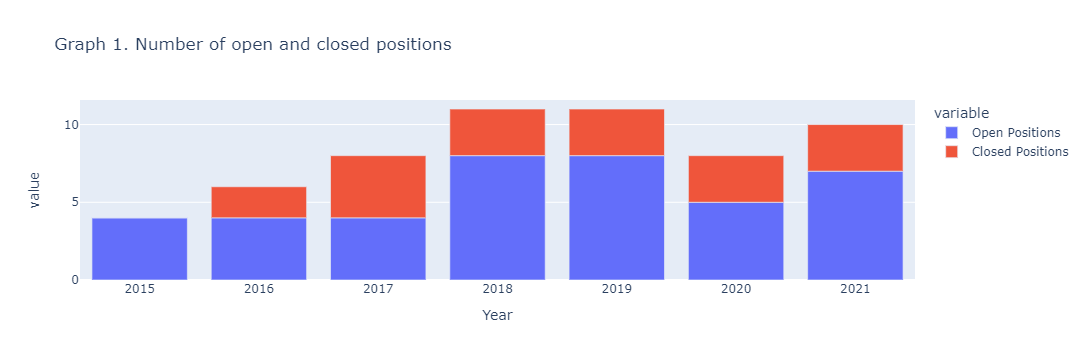

In [89]:
# get number of all complete iron condor transaction per year
all_trans = transaction.loc[transaction['OTM size'].isnull() != True].groupby(by = ['Year'])['OTM size'].count()/4
# get number of all offsetted iron condor transaction per year
closed_trans = transaction.loc[transaction['OTM size'].isnull() == True].groupby(by = ['Year'])['RIC'].count()/4

# create a dataframe of the all and offsetted transaction counts
all_trans_df = pd.concat([all_trans, closed_trans], axis =1, keys = ['All positions',  'Closed Positions']).reset_index().fillna(0)
# add a column of open positions by subtracting closed positions from all positions
all_trans_df['Open Positions'] = all_trans_df['All positions'] - all_trans_df['Closed Positions']

# plot the results
fig = px.bar(all_trans_df, x = "Year", y = ["Open Positions", "Closed Positions"], title ='Graph 1. Number of open and closed positions')
fig.show()

As can be observed from the graph above, there are missing transactions for several months throughout the years. This is because of lack of liquidity in Higer OTMs. For example, if we look at short iron condor example with 5%/10% legs we will observe many more complete transactions (you can try this by reading excel file "short_IC_10_20ndx1521.xlsx"). Additionally, we can notice from the graph that in average 3 transactions are offsite during the observation period. 

After we have complete short iron condor transactions, we visualize the outcome through multiple graphs. First, we look at the total and cumulative sum of profits during the observation period.

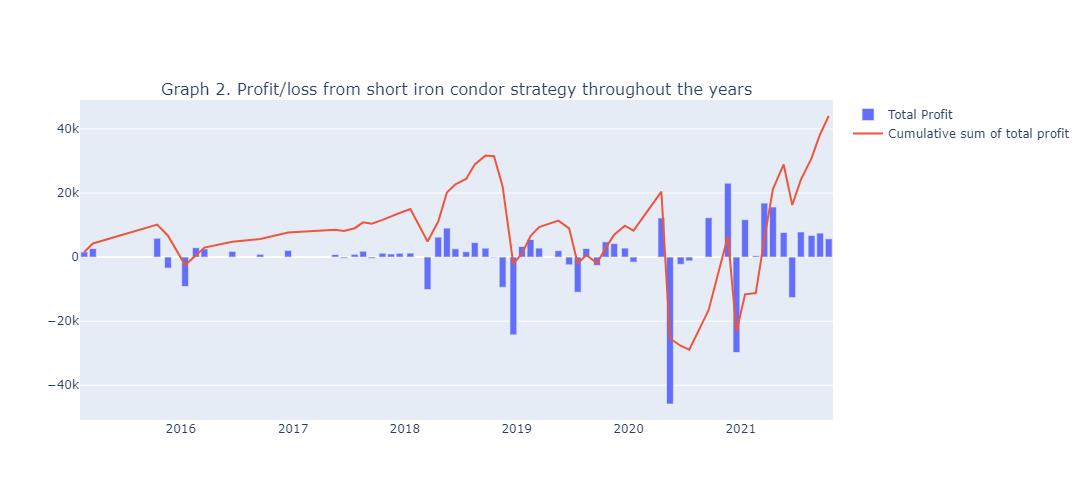

In [90]:
# get total profit/loss grouped by expiration date
df1 = transaction.groupby(by = ['Exp_date'])['Total Profit/Loss'].sum().reset_index()

# create subplots and show total and cumulative sum of of total profit over the years
fig = make_subplots(subplot_titles = ['Graph 2. Profit/loss from short iron condor strategy throughout the years'])
fig.add_trace(go.Bar(x=df1['Exp_date'], y=df1['Total Profit/Loss'], name = 'Total Profit'))
fig.add_trace(go.Line(x=df1['Exp_date'], y=df1['Total Profit/Loss'].cumsum(), name = 'Cumulative sum of total profit'))

fig.update_layout(height=500, width=1100)
fig.show()

The graph above illustrates, that short iron condor strategy on NDX with 10%/20% OTM legs was mostly positive in terms of the cumulative sum of profits. There were 3 big plunges  in the cumulative sum of the profits. First, was caused by stock market tank on December 2018 caused by the [interest rate hikes](https://www.cnbc.com/2019/01/09/markets-december-tumble-may-have-hinted-at-profit-revisions-to-come.html ) by Federal Reserve System which resulting an increased volatility. Next two profit drops on May 2020 and December 2020 are caused by volatility spikes because of the impact of COVID on stock markets. After the two latter crashes the cumulative sum of profits became negative which regained during the following periods when markets became more stable.

Further we look at the total profits and the ones attributed to Contract price and Exercise outcome components on an annual basis.

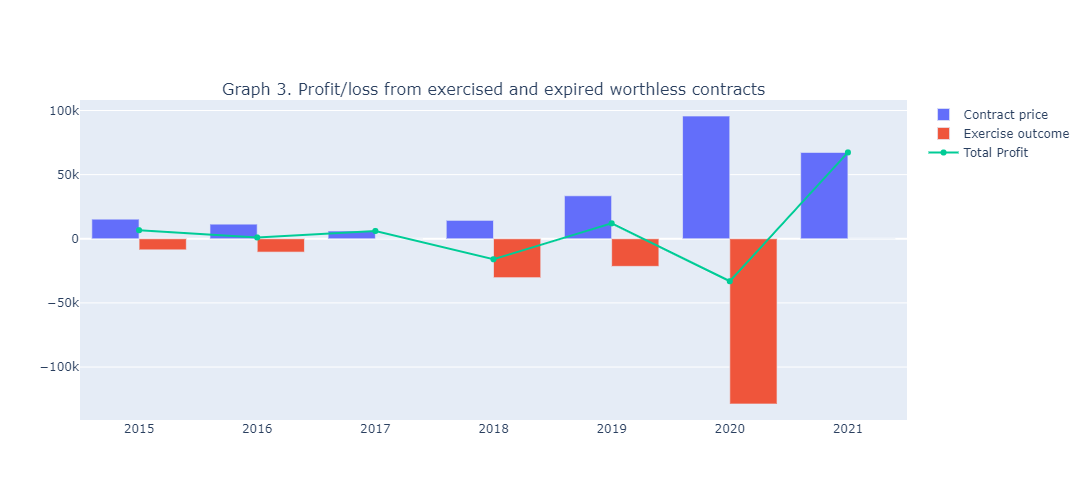

In [91]:
# create a dataframe of profits from Contract price and Exercise outcome gouped by year
newdf = transaction.groupby(by = ['Year'])['Contract price','Exercise outcome', 'Total Profit/Loss' ].sum().reset_index()

# plot the dataframe
fig = make_subplots(subplot_titles = ['Graph 3. Profit/loss from exercised and expired worthless contracts'])
fig.add_trace(go.Bar(x=newdf['Year'], y=newdf['Contract price'], name = 'Contract price'))
fig.add_trace(go.Bar(x=newdf['Year'], y=newdf['Exercise outcome'], name = 'Exercise outcome'))
fig.add_trace(go.Line(x=newdf['Year'], y=newdf['Total Profit/Loss'], name = 'Total Profit'))

fig.update_layout(height=500, width=1100)
fig.show()

Here we experience similar picture to the one from the graph above in terms of total profits. Particularly, we observe negative total profits for 2018 and 2020. The profit is reaching to its maximum in 2021. As expected, we can see that the profits are generated from contract price differences, whereas Exercised options resulted in loses. This is because one benefits from short iron condor strategy when the price is between strike prices of short positions and options become worthless at expiration. 

Next, we look also at the number of exercised and expired worthless contracts along with total profits.

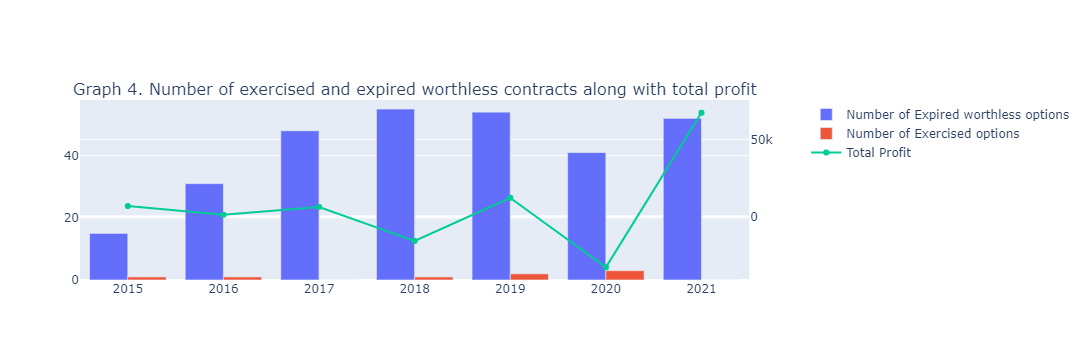

In [93]:
df2 = transaction.groupby(by = ['Year', 'Outcome', 'Trans_Date', 'Exp_date', 'Option type', 'Position'])['Total Profit/Loss'].sum().reset_index()

# create separate dataframes for number of erxercised, expired options and profits grouped by year
exer = df2.groupby('Year')['Outcome'].apply(lambda x: x[x == 'Exercised option'].count()).reset_index()
exp = df2.groupby('Year')['Outcome'].apply(lambda x: x[x == 'Expired worthless'].count()).reset_index()
prof = df2.groupby(by = ['Year'])['Total Profit/Loss'].sum().reset_index()

# plot the results using barplots and lineplot
fig = make_subplots(specs=[[{"secondary_y": True}]], subplot_titles = ['Graph 4. Number of exercised and expired worthless contracts along with total profit'])
fig.add_trace(go.Bar(x = exp['Year'], y = exp['Outcome'], name = "Number of Expired worthless options"), secondary_y = False)
fig.add_trace(go.Bar(x = exer['Year'], y = exer['Outcome'], name = "Number of Exercised options"), secondary_y = False)
fig.add_trace(go.Line(x = prof['Year'], y = prof['Total Profit/Loss'], name = "Total Profit"), secondary_y = True)
fig.show()

We can see from the graph above that most of the options expired worthless, and only 1-3 options contracts exercised which eventually resulted in loses which are presented in the previous graph. Particularly 3 exercised options from 2020 resulted in losses of $128,818.

Furter we deep dive and have a closer look at the individual components of iron condor strategy, such as profits from call options versus put options, short positions versus long positions and also profits from 4 different legs of the strategy. First we create the dataframes as shown in the cell below and then plot the results.

In [95]:
# create dataframe for profits from exercised versus expired options 
df3 = df2.groupby(by = ['Year', 'Outcome'])['Total Profit/Loss'].sum().reset_index()
exer = df3.loc[df3["Outcome"] == "Exercised option"]
exp = df3.loc[df3["Outcome"] == "Expired worthless"]

# create dataframe for profits from call versus put options 
df4 = df2.groupby(by = ['Year', 'Option type'])['Total Profit/Loss'].sum().reset_index()
call = df4.loc[df4["Option type"] == "call"]
put = df4.loc[df4["Option type"] == "put"]

# create dataframe for profits from short versus long positions 
df5 = df2.groupby(by = ['Year', 'Position'])['Total Profit/Loss'].sum().reset_index()
short = df5.loc[df5["Position"] == "short"]
long = df5.loc[df5["Position"] == "long"]

# create dataframe for profits from different legs of short iron condor strategy
df6 = df2.groupby(by = ['Year', 'Position', 'Option type'])['Total Profit/Loss'].sum().reset_index()
df6['Option'] = df6['Position'] + df6['Option type']
Long_call = df6.loc[df6["Option"] == "longcall"]
long_put = df6.loc[df6["Option"] == "longput"]
short_call = df6.loc[df6["Option"] == "shortcall"]
short_put = df6.loc[df6["Option"] == "shortput"]

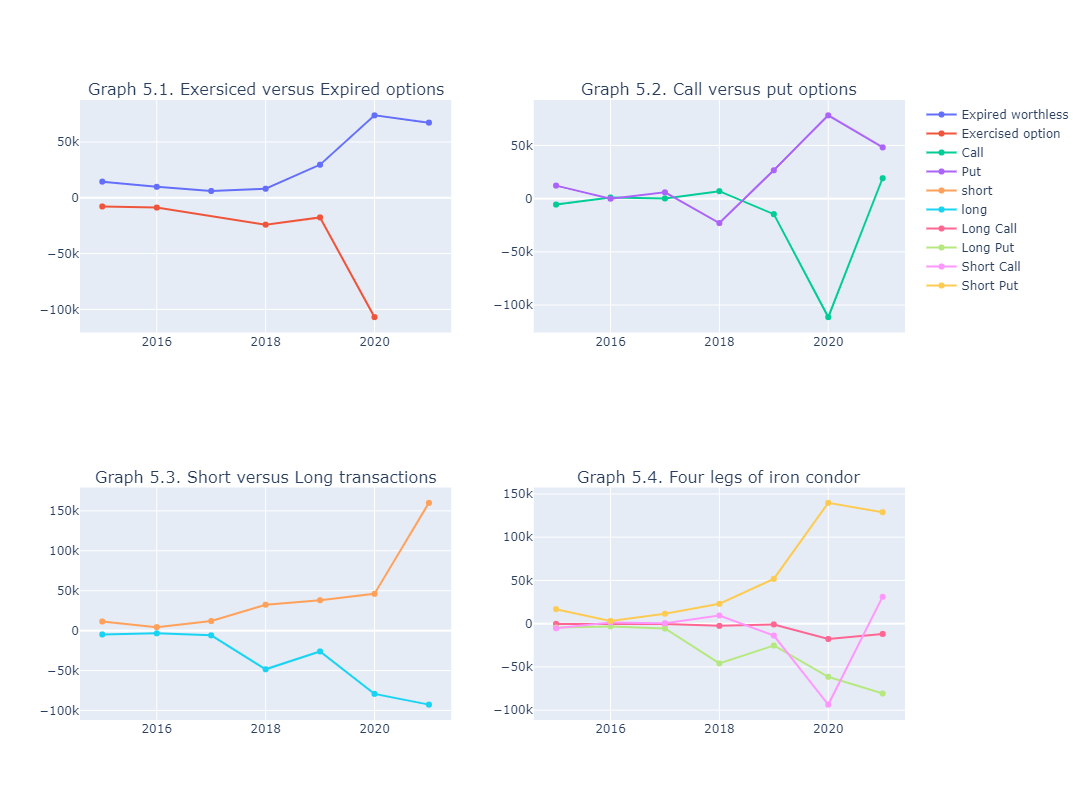

In [101]:
fig = make_subplots(rows=2, cols=2, subplot_titles = ['Graph 5.1. Exersiced versus Expired options', 'Graph 5.2. Call versus put options', 
                                                      'Graph 5.3. Short versus Long transactions', 'Graph 5.4. Four legs of iron condor'])

fig.add_trace(go.Line(x=exp["Year"], y=exp["Total Profit/Loss"], name = 'Expired worthless'), row=1, col=1)
fig.add_trace(go.Line(x=exer["Year"], y=exer["Total Profit/Loss"], name = 'Exercised option'), row=1, col=1)

fig.add_trace(go.Line(x=call["Year"], y=call["Total Profit/Loss"], name = 'Call'), row=1, col=2)
fig.add_trace(go.Line(x=put["Year"], y=put["Total Profit/Loss"], name = 'Put'), row=1,col=2)

fig.add_trace(go.Line(x=short["Year"], y=short["Total Profit/Loss"], name = 'short'), row=2, col=1)
fig.add_trace(go.Line(x=long["Year"], y=long["Total Profit/Loss"], name = 'long'), row=2,col=1)

fig.add_trace(go.Line(x=Long_call["Year"], y=Long_call["Total Profit/Loss"], name = 'Long Call'), row=2, col=2)
fig.add_trace(go.Line(x=long_put["Year"], y=long_put["Total Profit/Loss"], name = 'Long Put'),  row=2,col=2)
fig.add_trace(go.Line(x=short_call["Year"], y=short_call["Total Profit/Loss"], name = 'Short Call'), row=2, col=2)
fig.add_trace(go.Line(x=short_put["Year"], y=short_put["Total Profit/Loss"], name = 'Short Put'),  row=2,col=2)

fig.update_layout(height=800, width=1100)
fig.for_each_yaxis(lambda axis: axis.title.update(font=dict(color = 'blue', size=5)))

fig.show()

Looking at the graphs one by one, we can observe that as expected expired options resulted in most of the profits and exercised one loses. Moving to profits from call versus put options, we can claim that put options were mostly profitable and call options resulted in loses with an exception from 2018. Additionally short transactions when we received option premium resulted in profits and long positions to loses which is expected since most of the contracts expired worthless. Finally, short put options contributed most to the returns of the strategy, whereas long put and short call legs resulted in mostly loses. This is merely because market moved mostly upwards during the observation period. 

Finally, we plot the returns from the strategy per months to see whether there is a tendency for short iron condor strategy to be mostly profitable or losable during certain months on regularly basis.

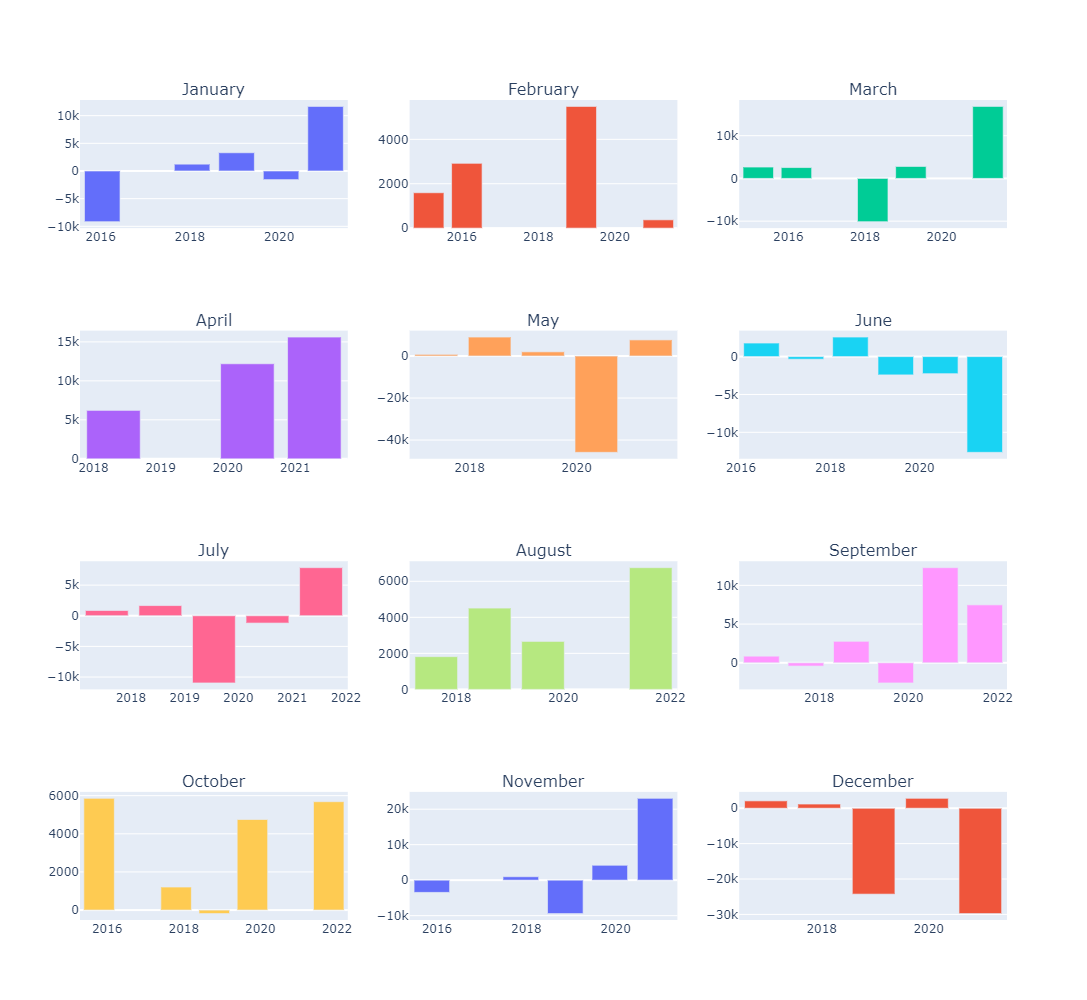

In [102]:
fig = make_subplots(rows=4, cols=3, subplot_titles = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'] )

n = 0
for i in range(1,5):
    for j in range(1, 4):
        n += 1
        x = df1['Exp_date'].loc[(df1['Exp_date'].dt.month==n)]
        y = df1['Total Profit/Loss'].loc[(df1['Exp_date'].dt.month==n)]
        fig.add_trace(
            go.Bar(x=x , y=y,showlegend=False),
            row=i, col=j
        )
fig.update_layout(height=1000, width=1100)

fig.show()

## Summary

### Limitation:
>1. Not easily scaleable to other options - you may need to learn exchange rules and rebild the RIC reconstuction logic
>2. You need a lot of API requests so depending on the option and number of years to request you may hit the daily limit
>3. When you look at larger OTMs, market get's illiquid and you may end up having no option contract to buy for some months
>4. Option contract may be very different depending on a day you purchase, especially in larger OTMs